In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import torch.cuda.amp as amp
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import wandb

from wavenet import model, train, sample, audio, datasets, utils, viz

# What do the forced conditional distributions look like

Let's take some ground truth, and hold it up to a pretrained model. Each timestep will have a single teacher forced distribution, the easiest case for the model.

In [3]:
m, ptrain = sample.load('purzelrakete/feldberlin-wavenet/3m0xq7hr')
m.cfg.dataset

'Sines(nseconds: 1)'

In [4]:
d = datasets.Sines(16, 1, m.cfg)
batch = datasets.to_tensor(d)

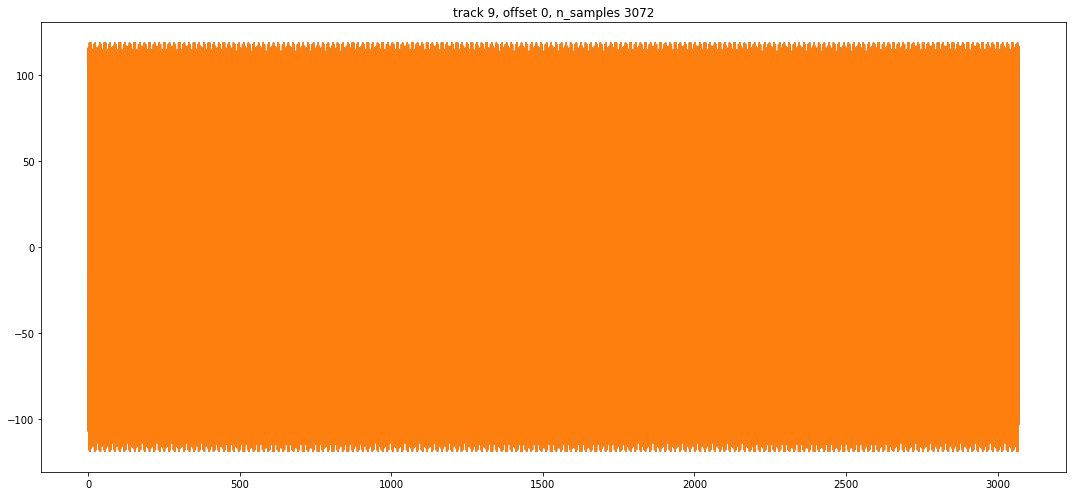

In [5]:
track_i = viz.plot_track(batch, n_samples=m.cfg.receptive_field_size())

In [6]:
for t in batch:
    t = utils.quantized_audio_to_unit_loudness(t.numpy(), m.cfg)
    t = audio.mu_expand(t, m.cfg)
    display(ipd.Audio(t, rate=m.cfg.sampling_rate))

In [7]:
device = torch.cuda.current_device()
with amp.autocast(enabled=m.cfg.mixed_precision):
    m = m.to(device)
    batch = batch.to(device)
    with torch.set_grad_enabled(False):
        logits, loss = m.forward(batch)

In [20]:
posterior = F.softmax(logits, dim=1).cpu().numpy()
N, K, C, W = posterior.shape

<BarContainer object of 256 artists>

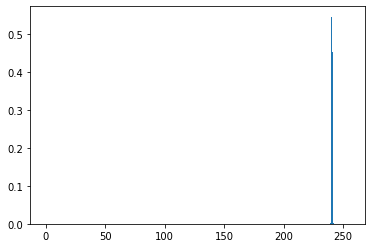

In [45]:
plt.bar(list(range(K)), posterior[10, :, 0, 10000])